In [5]:
# Directories
import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Academics\1_PAPER\2_Analysis")
print(os.getcwd())

E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Academics\1_PAPER\2_Analysis


In [6]:
#Array packages
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4

from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.ticker as ticker

#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy


# 1.Preprocessing

In [7]:
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg']
lsm_new=lsm.rename({i:f'{i}_C' for i in var})
lsm_new

NameError: name 'lsm' is not defined

## Method 1 : Calculating RE for each grid than seeing mean average

In [14]:
ss=2
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_m=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDc"]
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','RE']
var_c=var+[f'{i}_C' for i in var]

gdf = gpd.read_file('DATA_p/Shapefiles/India_trans/India_trans_new.shp')
basin=np.array(gdf.iloc[:,2])

lsm = xr.open_mfdataset(f"DATA_p/{model[1]}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})
lsm=lsm[var[0:3]]
lsm_c = xr.open_mfdataset(f"DATA_p/{model[4]}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})
lsm_c=lsm_c[var[0:3]]
lsm_c=lsm_c.rename({i:f'{i}_C' for i in var[0:3]})

lsm_merg=xr.merge([lsm, lsm_c])
lsm_merg=lsm_merg.where(lsm_merg>=0)

#datapreprocessing
lsm_merg=lsm_merg*60*60*24*30
lsm_merg=lsm_merg.where(lsm_merg>=0)
lsm_merg=lsm_merg.sel(time=lsm_merg["time.month"].isin(ssn_m[ss]))
lsm_merg=lsm_merg.groupby("time.year").mean(dim="time")


RE=lsm_merg["Qs_tavg"]/lsm_merg["TotalPrecip_tavg"]
RE = RE.where(~np.isinf(RE))
lsm_merg=lsm_merg.where(RE<0.8)
lsm_merg['RE']=RE
lsm_merg


RE=lsm_merg["Qs_tavg_C"]/lsm_merg["TotalPrecip_tavg_C"]
RE = RE.where(~np.isinf(RE))
lsm_merg=lsm_merg.where(RE<0.8)
lsm_merg['RE_C']=RE
lsm_merg


## Clipping into regions
dataset=[]
for i in range(len(basin)):
    
    B=gdf[gdf['Basin'] == basin[i]]
    lsm_merg.rio.set_spatial_dims(y_dim="lat",x_dim="lon", inplace=True)
    lsm_merg.rio.write_crs("EPSG:4326", inplace=True)
    clipped_ds = lsm_merg.rio.clip(B.geometry.apply(mapping), B.crs, drop=True)
    A=clipped_ds.mean(dim=['lat','lon']).expand_dims(dim='region')
    dataset.append(A)
lsm_merg_R = xr.concat(dataset, dim='region')
lsm_merg_R['region'] = basin




C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


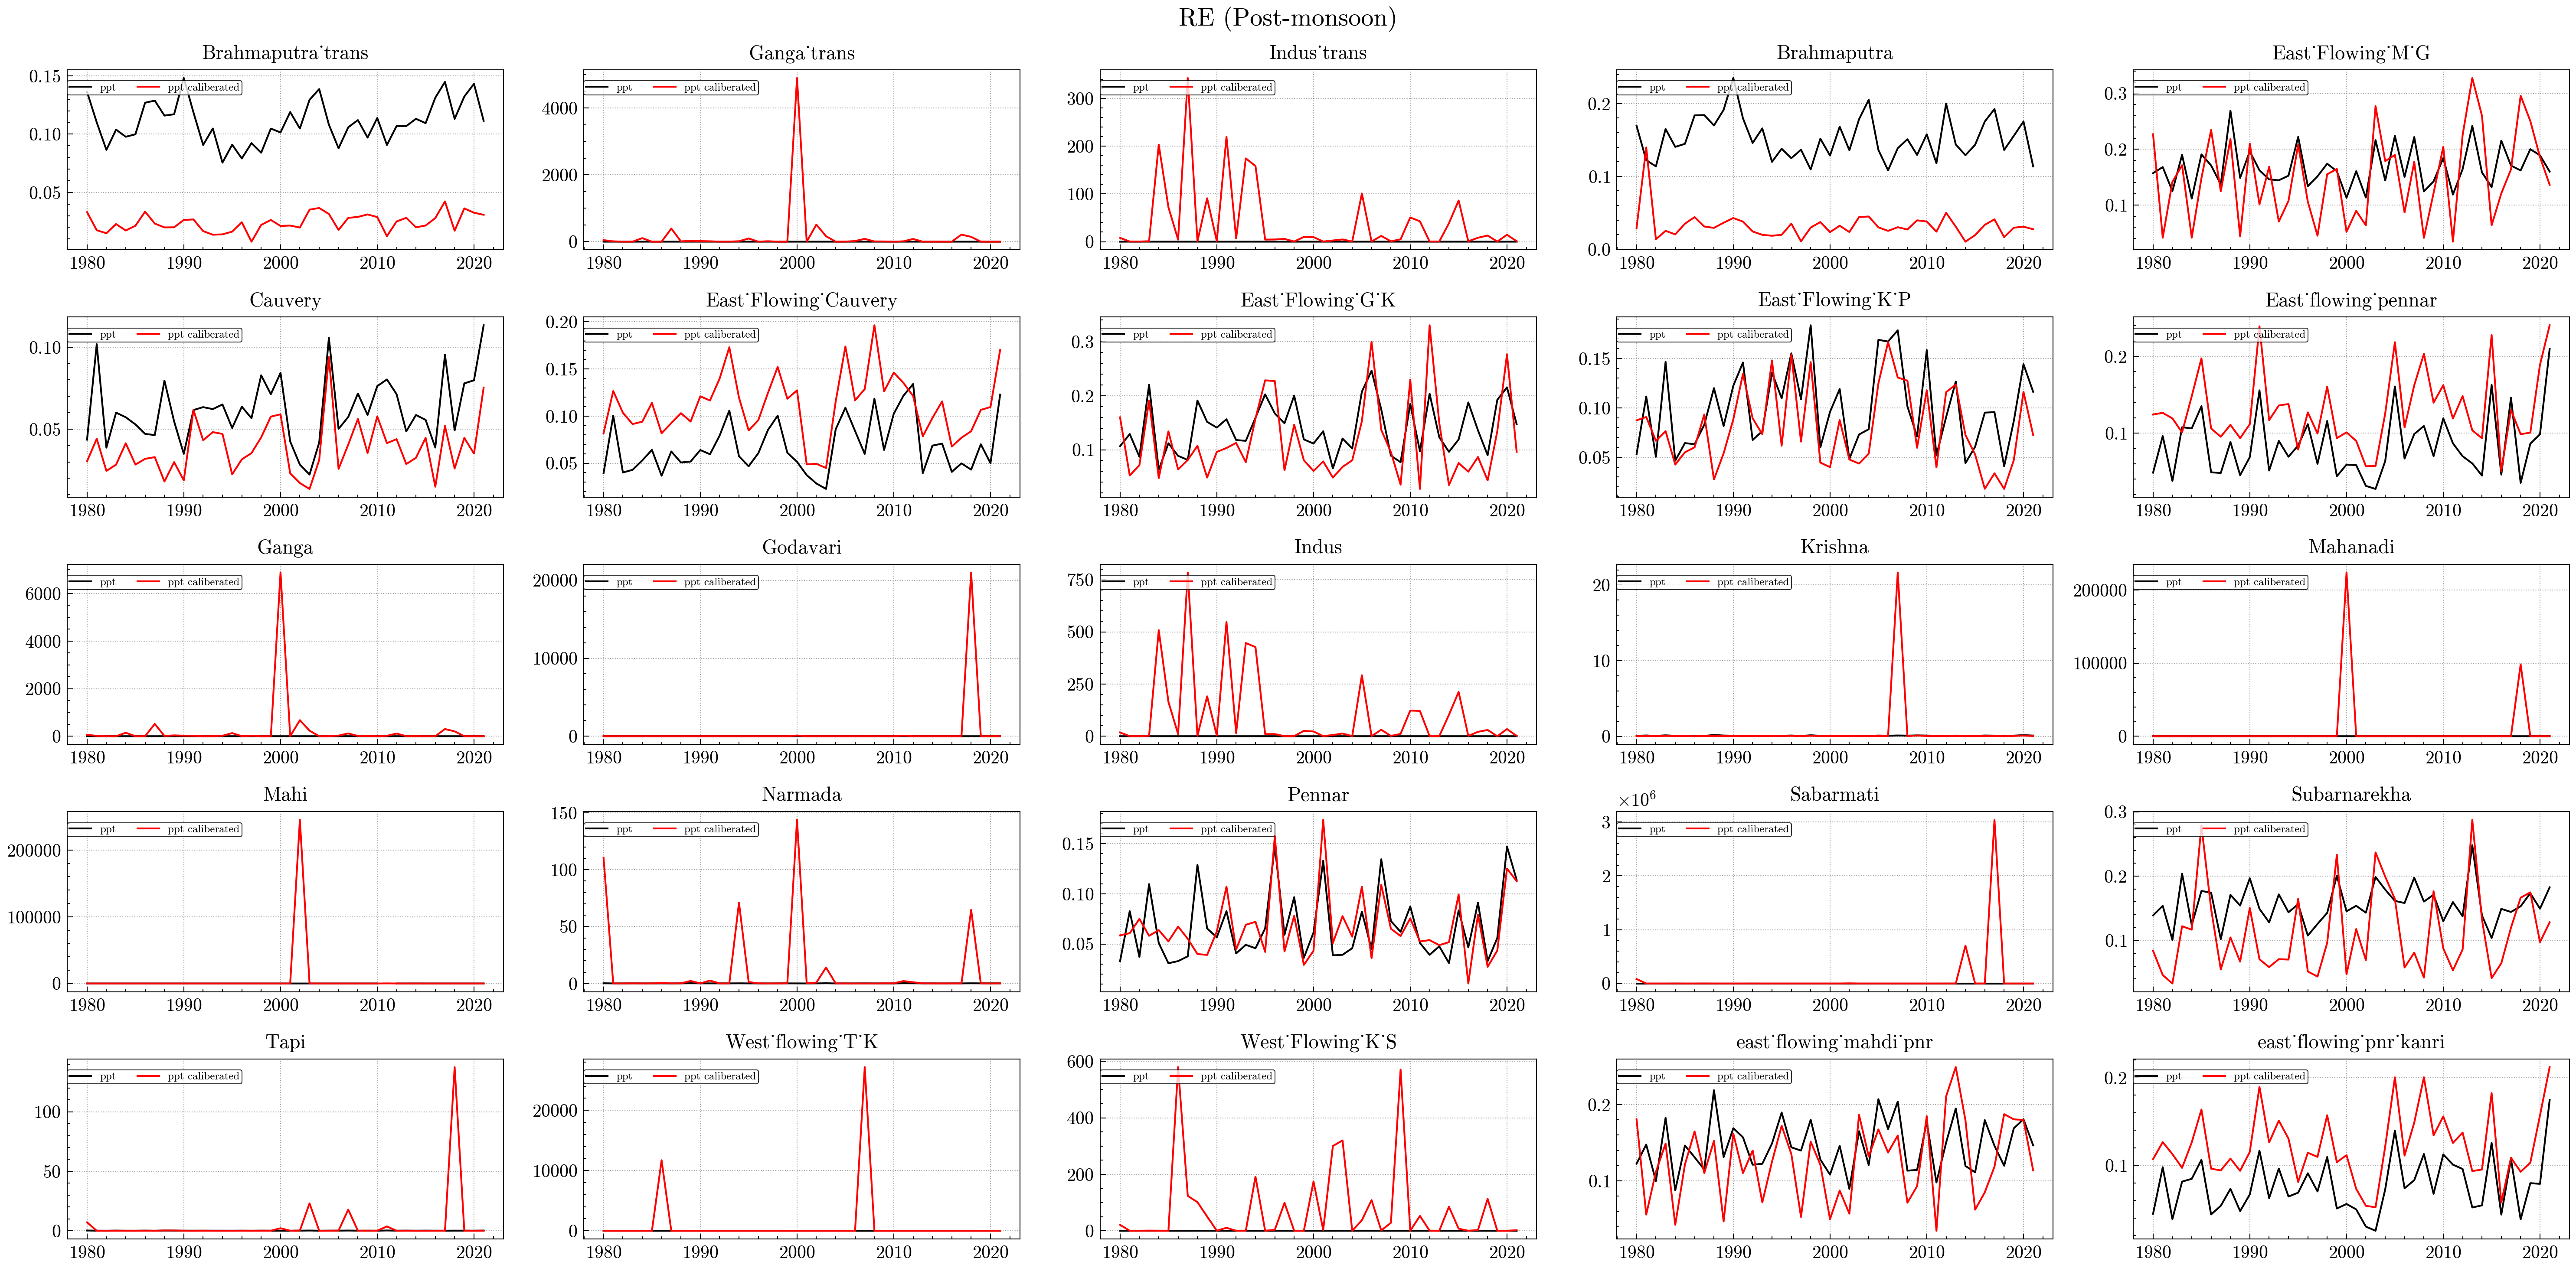

In [15]:
A=lsm_merg_R[var_c[0:4]]
A_c=lsm_merg_R[var_c[4:8]]

fig, ax = plt.subplots(5,5,figsize=(20,10), facecolor='white', dpi=300)
ax=ax.flatten()
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','RE']
vr=3
for i in range(25):
        
    import scienceplots
    plt.style.use(['science','no-latex','bright'])

    #np.arange(0,len(A['year']),1)
    yr=A['year']
    ppt=A[var_c[vr]].isel(region=i)
    ppt_c=A_c[var_c[4+vr]].isel(region=i)
    
    
    lw=1;al=1
    
    ax[i].plot(yr, ppt, color='Black', label='ppt', alpha=al, linewidth=lw)
    ax[i].plot(yr, ppt_c, color='red', label='ppt caliberated', alpha=al, linewidth=lw)
    
    #plt.xticks(np.arange(1980, 2020+1, 5.0))
    ax[i].grid(True, color= 'grey', alpha=0.7, linestyle='dotted')
    #ax[i].set_facecolor(df['colour'][i])  

    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax[i].xaxis.set_tick_params(which='both', bottom=True, top=False)
    ax[i].yaxis.set_tick_params(which='both', left=True, right=False)
    
    
    #ax[i].set_xlabel('$\mathbf{Year}$', fontsize=14)
    #ax[i].set_ylabel('RE', fontsize=14,labelpad=8, weight='bold')
    ax[i].set_title(f'{basin[i]}', fontsize=11)
    
    lgnd=ax[i].legend(loc='center', ncol=2,fontsize=6, bbox_to_anchor=(0.2, 0.90),frameon=True, borderpad=0.2, edgecolor='black')
    frame = lgnd.get_frame()
    frame.set_linewidth(0.5)
    fig.suptitle(f'{var[vr]} ({ssn[ss]})', fontsize=14,fontweight='bold')

plt.tight_layout()
plt.savefig(f'1_Preliminary checks/output/imd vs imdc/{ssn[ss]}.png',dpi=300)
plt.show()

## Method 2 : Calculating regional average then find RE

In [35]:
ss=1
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_m=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDc"]
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','RE']
var_c=var+[f'{i}_C' for i in var]

gdf = gpd.read_file('DATA_p/Shapefiles/India_trans/India_trans_new.shp')
basin=np.array(gdf.iloc[:,2])

lsm = xr.open_mfdataset(f"DATA_p/{model[1]}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})
lsm=lsm[var[0:3]]
lsm_c = xr.open_mfdataset(f"DATA_p/{model[4]}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})
lsm_c=lsm_c[var[0:3]]
lsm_c=lsm_c.rename({i:f'{i}_C' for i in var[0:3]})

lsm_merg=xr.merge([lsm, lsm_c])
lsm_merg=lsm_merg.where(lsm_merg>=0)


#datapreprocessing
lsm_merg=lsm_merg*60*60*24*30
lsm_merg=lsm_merg.where(lsm_merg>=0)
lsm_merg=lsm_merg.sel(time=lsm_merg["time.month"].isin(ssn_m[ss]))
lsm_merg=lsm_merg.groupby("time.year").mean(dim="time")



## Clipping into regions
dataset=[]
for i in range(len(basin)):
    
    B=gdf[gdf['Basin'] == basin[i]]
    lsm_merg.rio.set_spatial_dims(y_dim="lat",x_dim="lon", inplace=True)
    lsm_merg.rio.write_crs("EPSG:4326", inplace=True)
    clipped_ds = lsm_merg.rio.clip(B.geometry.apply(mapping), B.crs, drop=True)
    A=clipped_ds.mean(dim=['lat','lon']).expand_dims(dim='region')
    dataset.append(A)
lsm_merg_R = xr.concat(dataset, dim='region')
lsm_merg_R['region'] = basin


RE1 = lsm_merg_R["Qs_tavg"]/lsm_merg_R["TotalPrecip_tavg"]
RE1 = RE1.where(~np.isinf(RE1))
RE1 = RE1.where(RE1<0.8)
lsm_merg_R['RE']=RE1

RE2=lsm_merg_R["Qs_tavg_C"]/lsm_merg_R["TotalPrecip_tavg_C"]
RE2 = RE2.where(~np.isinf(RE2))
RE2=RE2.where(RE2<0.8)
lsm_merg_R['RE_C']=RE2

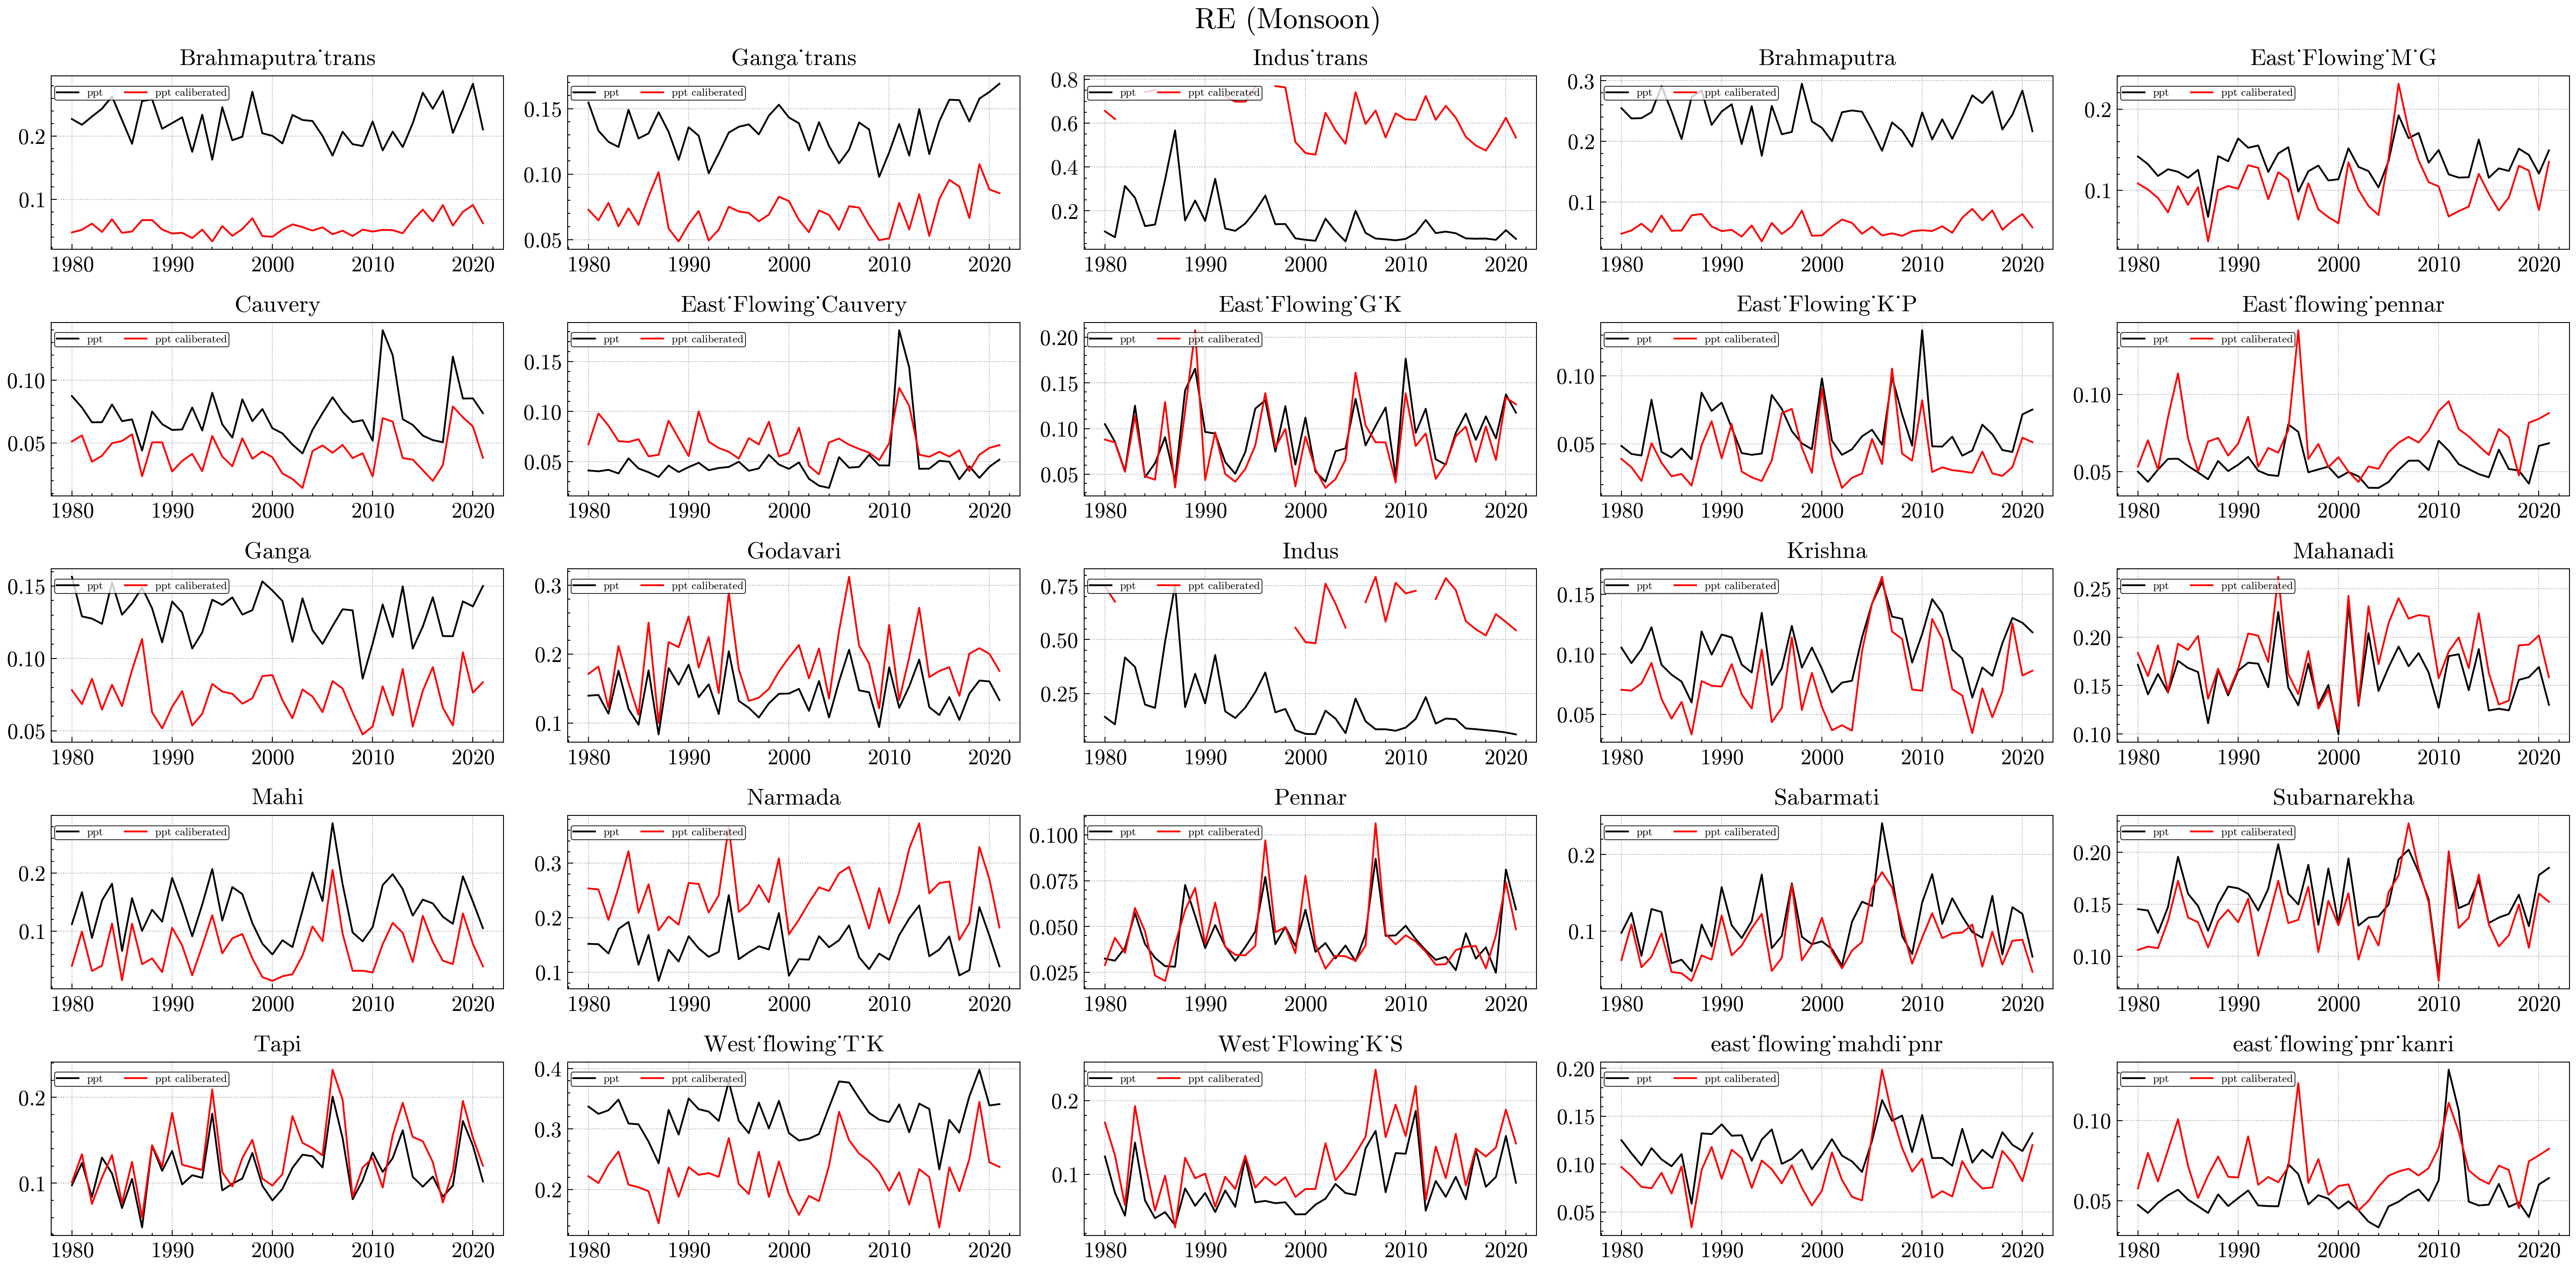

In [37]:
A=lsm_merg_R[var_c[0:4]]
A_c=lsm_merg_R[var_c[4:8]]

fig, ax = plt.subplots(5,5,figsize=(20,10), facecolor='white', dpi=300)
ax=ax.flatten()
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','RE']
vr=3
for i in range(25):
        
    import scienceplots
    plt.style.use(['science','no-latex','bright'])

    #np.arange(0,len(A['year']),1)
    yr=A['year']
    ppt=A[var_c[vr]].isel(region=i)
    ppt_c=A_c[var_c[4+vr]].isel(region=i)
    
    
    lw=1;al=1
    
    ax[i].plot(yr, ppt, color='Black', label='ppt', alpha=al, linewidth=lw)
    ax[i].plot(yr, ppt_c, color='red', label='ppt caliberated', alpha=al, linewidth=lw)
    
    #plt.xticks(np.arange(1980, 2020+1, 5.0))
    ax[i].grid(True, color= 'grey', alpha=0.7, linestyle='dotted')
    #ax[i].set_facecolor(df['colour'][i])  

    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax[i].xaxis.set_tick_params(which='both', bottom=True, top=False,labelsize=12)
    ax[i].yaxis.set_tick_params(which='both', left=True, right=False,labelsize=12)
    
    
    #ax[i].set_xlabel('$\mathbf{Year}$', fontsize=14)
    #ax[i].set_ylabel('RE', fontsize=14,labelpad=8, weight='bold')
    ax[i].set_title(f'{basin[i]}', fontsize=13)
    
    lgnd=ax[i].legend(loc='center', ncol=2,fontsize=6, bbox_to_anchor=(0.2, 0.90),frameon=True, borderpad=0.2, edgecolor='black')
    frame = lgnd.get_frame()
    frame.set_linewidth(0.5)
    fig.suptitle(f'{var[vr]} ({ssn[ss]})', fontsize=16,fontweight='bold')

plt.tight_layout()
plt.savefig(f'1_Validation/output/LISimd vs LISimd_c/{ssn[ss]}_LISIMD_C_B.png',dpi=300)
plt.show()